<a href="https://colab.research.google.com/github/ErfanRasti/MachineLearningProjects/blob/main/NaturalLanguageProcessing/NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='green'>NLP Project</font>

<div class="alert alert-block alert-warning">
<b>
Amirkabir University of Technology<br>
Fall 2022<br>
Course: Machine Learning<br>
Instructor: Dr. Seyedin<br>
<b><font color='green'>Authors:</font></b><br>
Name: Amir Azad<br />
Student Number: 9823004</div>
Name: Erfan Rasti<br />
Student Number: 9823034</div>


***

# <font color='purple'>Importing Required Packages</font>

In [ ]:
# ! pip install transformers
# ! pip install datasets
# ! pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 71.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 111.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 17.5 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wh

In [ ]:
from transformers import AutoTokenizer
from transformers import BertTokenizer, BertForSequenceClassification
import pandas as pd
import torch
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn import metrics
from sentence_transformers import SentenceTransformer
import numpy as np

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
torch.cuda.get_device_name(0)

'Tesla T4'

# <font color='purple'>Loading the dataset from Hugging Face</font>

In [ ]:
from datasets import load_dataset
dataset = load_dataset('tweet_eval', 'hate')

Extracting data files:   0%|          | 0/6 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/9000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2970 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset tweet_eval downloaded and prepared to /root/.cache/huggingface/datasets/tweet_eval/hate/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2970
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1000
    })
})


In [ ]:
print(dataset['train'][0])
print(dataset['test'][2])

{'text': '@user nice new signage. Are you not concerned by Beatlemania -style hysterical crowds crongregating on you…', 'label': 0}
{'text': '@user @user Those People Invaded Us!!! They DO NOT BELING HERE & HAVE NO RIGHTS! Its #AmericaFIRST! Open Your House To Them If Your That IGNORANT! & Yes Im A #Christian Too! #NODACA!', 'label': 1}


# <font color='purple'>Preprocessing Data</font>


In [ ]:
def preprocess_sentence(sentence):
    # remove punctuation
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    # remove numbers
    sentence = re.sub(r'\d+', '', sentence)
    # remove whitespace
    sentence = sentence.strip()
    # remove stopwords
    sentence = ' '.join([word for word in sentence.split() if word not in stopwords.words('english')])
    return sentence

In [ ]:
def preprocess_dataset(dataset):
    dataset = dataset.map(lambda examples: {'text': preprocess_sentence(examples['text'])})
    return dataset

In [ ]:
dataset = preprocess_dataset(dataset)
print(dataset['train'][0])
print(dataset['test'][2])

  0%|          | 0/9000 [00:00<?, ?ex/s]

  0%|          | 0/2970 [00:00<?, ?ex/s]

  0%|          | 0/1000 [00:00<?, ?ex/s]

{'text': 'user nice new signage Are concerned Beatlemania style hysterical crowds crongregating you…', 'label': 0}
{'text': 'user user Those People Invaded Us They DO NOT BELING HERE HAVE NO RIGHTS Its AmericaFIRST Open Your House To Them If Your That IGNORANT Yes Im A Christian Too NODACA', 'label': 1}


In [ ]:
from transformers import DistilBertTokenizer

#You can use bert-base or DistilBert as a model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

def tokenize_dataset(dataset):
    tokenized_dataset = dataset.map(lambda examples: tokenizer(examples['text'], truncation=True, padding='max_length'), batched=True)
    return tokenized_dataset

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/9d7568e4b20ed5db15ee30e99c7219bde9990762/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/9d7568e4b20ed5db15ee30e99c7219bde9990762/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/9d7568e4b20ed5db15ee30e99c7219bde9990762/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-cased",
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_

In [ ]:
dataset = tokenize_dataset(dataset)
print(dataset['train'][0])
print(dataset['validation'][0])
print(dataset['test'][2])

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

{'text': 'user nice new signage Are concerned Beatlemania style hysterical crowds crongregating you…', 'label': 0, 'input_ids': [101, 4795, 3505, 1207, 2951, 2553, 2372, 4264, 11938, 14183, 11262, 1947, 177, 21878, 4571, 13484, 172, 16822, 1874, 18401, 1128, 795, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

# <font color='purple'>Fine-tune a model</font>

You should complete this section

In [ ]:
from transformers import TrainingArguments
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    'distilbert-base-cased', num_labels=2)


training_args = TrainingArguments(output_dir="test_trainer")


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/9d7568e4b20ed5db15ee30e99c7219bde9990762/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-cased",
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.25.1",
  "vocab_size": 28996
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--distilbert-base-cased/snapshots/9d7568e4b20ed5db15ee30e99c7219bde9990762/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassif

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir="test_trainer")

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
! pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import evaluate

acc_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return  (acc_metric.compute(predictions=predictions,
                                       references=labels),
                precision_metric.compute(predictions=predictions,
                                              references=labels),
                recall_metric.compute(predictions=predictions,
                                        references=labels),
                f1_metric.compute(predictions=predictions,
                                references=labels))
    

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['validation'],
    compute_metrics=compute_metrics,
)

trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 9000
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3375
  Number of trainable parameters = 65783042


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.479400,0.533775,{'accuracy': 0.743},{'precision': 0.6640926640926641},{'recall': 0.8056206088992974},{'f1': 0.728042328042328}
2,0.354300,0.655491,{'accuracy': 0.74},{'precision': 0.6596558317399618},{'recall': 0.8079625292740047},{'f1': 0.7263157894736841}
3,0.223100,1.081620,{'accuracy': 0.744},{'precision': 0.6784968684759917},{'recall': 0.7611241217798594},{'f1': 0.7174392935982339}


Saving model checkpoint to test_trainer/checkpoint-500
Configuration saved in test_trainer/checkpoint-500/config.json
Model weights saved in test_trainer/checkpoint-500/pytorch_model.bin
Saving model checkpoint to test_trainer/checkpoint-1000
Configuration saved in test_trainer/checkpoint-1000/config.json
Model weights saved in test_trainer/checkpoint-1000/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Trainer is attempting to log a value of "{'accuracy': 0.743}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.66409266

TrainOutput(global_step=3375, training_loss=0.35426355206524884, metrics={'train_runtime': 1350.0213, 'train_samples_per_second': 20.0, 'train_steps_per_second': 2.5, 'total_flos': 3576619763712000.0, 'train_loss': 0.35426355206524884, 'epoch': 3.0})

# <font color='purple'>Evaluation</font>

You should complete this section

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 2970
  Batch size = 8


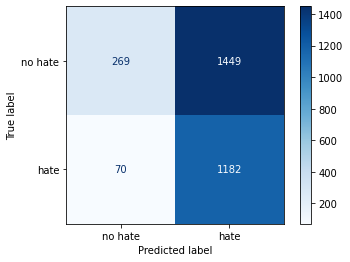

In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

test_pred = trainer.predict(dataset['test']).predictions.argmax(axis=1)
test_true = dataset['test']['label']
cm = confusion_matrix(test_true, test_pred)

cm_plot = ConfusionMatrixDisplay(
    cm, display_labels=['no hate', 'hate'])
cm_plot.plot(cmap='Blues')
plt.show()


# <font color='purple'>References</font>

1.   https://huggingface.co/metrics
2.   https://huggingface.co/docs/transformers/training
